# Introduction to Privacy Preserving Machine Learning

Course taught by Aurélien Bellet

# Lab session: Gaussian mechanism and Differentially Private SGD

In [13]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml  # need sklearn >= 0.22
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer

## <font color=red>Instructions for submitting your report</font>

<font color=red>The deadline for sending your report is **Friday, February 23, 2024 at 23h55**.
The report is **by teams of 2 students**, should only consist of a **single** `ipynb` file (Jupyter notebook) with your names indicated clearly, and be **submitted via Moodle** (Décision et apprentissage > TP Privacy-Preserving ML > Rendu TP).

The grade will be over 20 points, broken down as follows:
- Quality of your answers to the questions: **17** points
- Quality of the writing and presentation: **2** points
- Absence of any bug: **1** point

Penalties: **5** points per 12 hours of extra time; **2** points for any failure to respect the other instructions above.</font>

## Part 1: Gaussian mechanism on simple numeric queries

In this first part, we will implement the Gaussian mechanism and experiment with simple numeric queries.

### Dataset

We will be working with a dataset from the US Census (also known as the Adult dataset). You can read about the dataset [here](https://archive.ics.uci.edu/ml/datasets/census+income).

The following line loads the dataset from [OpenML](https://www.openml.org/) with the `fetch_openml` method of `sklearn`. The option `as_frame=True` (**requires sklearn version >= 0.22**) loads the dataset in `pandas DataFrame` format: this keeps the attributes in their original form and will be more convenient to work with.

In [14]:
dataset_handle = fetch_openml(name='adult', version=2, as_frame=True)
dataset = dataset_handle.frame

Take a look at the dataset, in particular the number of rows (individuals), the number of columns (attributes) and what they represent.

In [15]:
n, d = dataset.shape
print(n, d)
display(dataset.head(10))
dataset.describe()

48842 15


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K
5,34.0,Private,198693.0,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States,<=50K
6,29.0,NaN,227026.0,HS-grad,9.0,Never-married,NaN,Unmarried,Black,Male,0.0,0.0,40.0,United-States,<=50K
7,63.0,Self-emp-not-inc,104626.0,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103.0,0.0,32.0,United-States,>50K
8,24.0,Private,369667.0,Some-college,10.0,Never-married,Other-service,Unmarried,White,Female,0.0,0.0,40.0,United-States,<=50K
9,55.0,Private,104996.0,7th-8th,4.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,10.0,United-States,<=50K


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


### Question 1.1 (non-private queries)

Implement a function for each of these types of queries (without privacy) and test them on the dataset:
- **Simple count queries**: it takes as input a dataset (`DataFrame`), a categorical attribute (e.g., `"sex"`) and a value (e.g., `Male`), and returns how many rows in the dataset have the prescribed attribute value.
- **Averaging queries**: it takes as input a dataset and a numeric attribute (e.g., `"age"`), and returns the average value of this attribute in the dataset.
- **Histogram queries**: it takes as input a dataset and a categorical attribute (e.g., `"sex"`), and returns the histogram of counts for this attribute in the dataset (i.e., for each possible value of the attribute, how many rows have this value).

Reminder: for a DataFrame `df`, we can access the column corresponding to an attribute `attr` by `df[attr]`. The method `value_counts()` allows to build a histogram of a column.

Note: you can use the function `bar_plot_pandas` provided below to draw a bar plot of a pandas Series, which is useful to show histograms.

In [16]:
def bar_plot_pandas(series1, series2=None, label1="Series 1", label2="Series 2", title=""):
    '''
    Draws a bar plot of one Pandas Series, or two pandas Series with the same index
    
    Parameters
    ----------
    series1 : Series of float
        First input
    series2 : Series of float, optional
        Second input (with same index)
    label1 : string, optional
        Label for the first series
    label2 : string, optional
        Label for the second series
    title : string, optional
        Plot title
    '''
    if series2 is None:
        series1.plot.bar()
        plt.legend([label1])
    else:
        concat_series = pd.DataFrame({label1: series1, label2: series2}).reset_index()
        concat_series.plot.bar(x="index", y=[label1, label2], xlabel="", title=title)

In [17]:
def count_query(df, attribute, value):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataset
    attribute : string
        Name of an attribute with categorical values
    value : string or int
        Value of attribute to count
        
    Returns
    -------
    count : int
        The number of records with `attribute=value` in dataset `df`
    '''
    
    count = (df[attribute] == value).sum() # somme les lignes = True , ce qui donne le count
    return count

In [18]:
def average_query(df, attribute):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataset
    attribute : string
        Name of an attribute with numeric values
        
    Returns
    -------
    average : float
        The average value of `attribute` in dataset `df`
    '''
        
    average = df[attribute].mean() # moyenne
    return average

In [19]:
def histogram_query(df, attribute):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataset
    attribute : string
        Name of an attribute with categorical values
        
    Returns
    -------
    histogram : array or Series of int
        The histogram of `attribute`, i.e., the number of times each value of `attribute` appears in `df`
    '''
    
    histogram = df[attribute].value_counts() #compte le nombre d'apparition de chaque attribute dans df.
    return histogram

### Question 1.2 (Gaussian mechanism)

Implement the Gaussian mechanism, i.e., a function which takes as input a (non-private) query output, the query's $\ell_2$ sensitivity, the desired value of $\epsilon$ and $\delta$ and a random seed (for reproducibility), and returns a $(\epsilon,\delta)$-differentially private estimate of the query. To draw Gaussian noise, check `np.random.normal`. The function should work with queries that output a scalar (like simple count and averaging queries), as well as those that output a vector (like histogram queries).

In [20]:
def gaussian_mechanism(q, s2, eps, delta, random_state=None):
    '''
    Parameters
    ----------
    q : float or array/Series of float
        The non-private output of the query
    s2 : float
        The L2 sensitivity of the query
    eps : float
        Parameter epsilon of differential privacy
    delta : float
        Parameter delta of differential privacy
    random_state : int, optional (default=None)
        Random seed
        
    Returns
    -------
    private_q : float or array/Series of float
        An (eps,delta)-DP evaluation of the query
    '''
    
    rng = np.random.RandomState(random_state)
    
    if hasattr(q, 'shape'): # query output is multi-dimensional
        noise = rng.normal(loc=0, scale=s2 * np.sqrt(2*np.log(1.25/delta))/eps, size=q.shape)
        private_q = q + noise
    else: # query output is a scalar
        noise = rng.normal(loc=0, scale=s2 * np.sqrt(2*np.log(1.25/delta))/eps)
        private_q = q + noise
        
    return private_q


### Question 1.3 (Private computation of count queries)

We would like to use the Gaussian mechanism to:
- privately count the number of males in the dataset
- generate a private histogram of the `"workclass"` attribute

What is the sensitivity of the query in each case?

Run the Gaussian mechanism with different values of $\epsilon$ and $\delta$, and compute the relative $\ell_1$-error with respect to the true (non-private) output and discuss the effect of $\epsilon$ and $\delta$ on the utility. Recall that the mechanism is random, so unless you fix the seed you will get a different result at each execution. You may also visually compare the private and non-private histograms using the function `bar_plot_pandas` provided at the beginning of the notebook.

Note: you may round the outputs of the private mechanism to make them integers if you like. This can be seen as post-processing and thus preserves DP.

> For the count query, the sensitivity is 1. Changing one record will, in the worst case scenario, replace a male by a female or vice versa. 
>
> For the histogram query of the `"workclass"` attribute, the sensitivity is $\sqrt2$.

In [21]:
def relative_l1_error(q_true, q_est):
    '''
    Parameters
    ----------
    q_true : float or array/Series of float
        True value
    q_est : float or array/Series of float
        Estimated value
        
    Returns
    -------
    l1_error : float
        The relative L1 error of `q_est` with respect to and `q_true`: ||q_true-q_est||_1 / ||q_true||_1
    '''

    if  isinstance(q_true, (int, float)): #add to modify this line,elseit went through every time, event with float
        return np.abs(q_true - q_est) / np.abs(q_true)
    else:
        return np.linalg.norm(q_true - q_est, ord=1) / np.linalg.norm(q_true, ord=1)

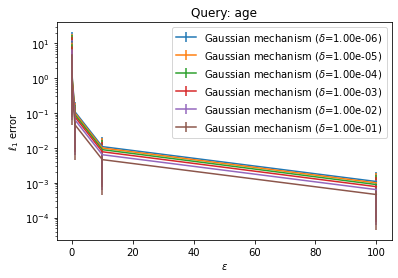

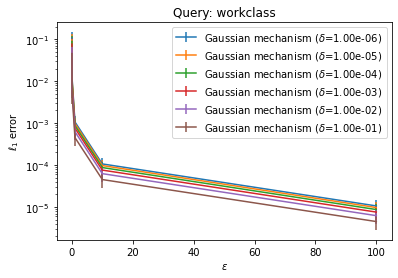

In [25]:
# fill with the list of queries in the format (name, query_function, sensitivity)
queries = [(dataset.columns[0], average_query, 1),('workclass', histogram_query, np.sqrt(2)),]

# fill with the list of values for epsilon and delta
eps_list = [0.01, 0.1, 1, 10, 100]
delta_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
n_runs = 10


for name, q, s in queries:
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    error = np.zeros((len(eps_list), len(delta_list), n_runs))
    for j, delta in enumerate(delta_list):
        for i, eps in enumerate(eps_list):
            for r in range(n_runs):
                q_true = q(dataset, name)
                q_est = gaussian_mechanism(q_true, s, eps, delta, random_state=r+3)
                # Compute relative L1 error
                error[i, j, r] = relative_l1_error(q_true, q_est)
        ax.errorbar(eps_list, error[:, j, :].mean(axis=1), error[:, j, :].std(axis=1),
                    label='Gaussian mechanism ($\delta$=' + "{:.2e}".format(delta) + ')')

    plt.xlabel("$\epsilon$")
    plt.ylabel("$\ell_1$ error")
    plt.title("Query: " + name)
    ax.set_yscale('log')
    ax.legend()

plt.show()

We can see that the relative $\ell_1$-error decreases when $\epsilon$ increases. The influence of $\delta$ is very small, but here as $\delta$ increases, the relative $\ell_1$-error increases

In [26]:
# Compare histograms
private_workclass = gaussian_mechanism(histogram_query(dataset, 'workclass'), np.sqrt(2), 1e-3, 1e-2)
hist=histogram_query(dataset, 'workclass')

import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='True', x=hist.index, y=hist),
    go.Bar(name='Private', x=hist.index, y=private_workclass)
])
#add title
fig.update_layout(title_text='Workclass histogram')
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

> Using plotly you can choose to hide/show one histogram by clicking on the legend and you can see the exact values of the bars by hovering over them.
>
> We can easily see the effect of the gaussian noise on the histogram. On the most frequent values, the noise is not very visible, but on the less frequent values, the noise is more visible and can even change the sign of the value.

### <font color='blue'>Bonus Question</font> (Private computation of  average queries)
*(You won't be penalized if you don't answer this question; but can get bonus points if you do)*

We would like to use the Gaussian mechanism to privately estimate the average age of people in the dataset.

1. Propose and implement simple practical strategies to compute or estimate the sensitivity of this query in the following two scenarios, and discuss the merits and/or drawbacks of your proposals:
  - You are the trusted curator: you have access to the raw dataset and would like to release an estimate of the average age of people in the dataset with differential privacy guarantees.
  - You are an external data analyst: you do not have access to the raw dataset but only to an API to send queries. You have to convince the trusted curator that the sensitivity you propose is safe.
2. Suggest some ideas regarding how we could change a bit the query to get a simple and safe bound on sensitivity, at the expense of possibly introducing some bias in the output. Implement the proposed solution. Hint: the method `clip` from pandas might be useful here.

#### Scenario 1: Trusted Curator
> As a trusted curator with full access to the dataset, we can directly compute the sensitivity based on the exact range of ages.
>
> Our strategy is based on **Exact Sensitivity Calculation:** We can calculate the sensitivity as the maximum possible change in the average age when an individual is added or removed from the dataset. 
> - This strategy has the merit that this precise calculation provides the most accurate sensitivity, ensuring the minimal amount of noise for the desired privacy level. 
> 
> - But, as a drawback, this method exposes the curator to the exact range of ages, which might be sensitive if the dataset is small or if extreme ages are rare or sensitive.

#### Scenario 2: External Data Analyst
> As an external analyst without access to the raw data, proposing a sensitivity requires assumptions or agreements with the curator.
>
> Our strategy is based on **Agreed-Upon Bounds:** Agree on a plausible range of ages (e.g., 0 to 100 years) to calculate a theoretical maximum sensitivity for the average age query. This bounds the change in average age due to the addition or removal of a single record.
> - This strategy has the merit that it does not require access to the raw data, respecting privacy constraints and provides a clear and understandable sensitivity measure that can be easily communicated and agreed upon.
>
> - But, as a drawback, this method may overestimate the sensitivity if the agreed-upon range is much wider than the actual range of ages in the dataset, leading to unnecessary noise being added. The fixed age range might not apply well to specific populations with a different age distribution.

In [28]:
def clipped_average_age(df, lower_bound=0, upper_bound=100):
    clipped_ages = df['age'].clip(lower_bound, upper_bound)
    average_age = clipped_ages.mean()
    return average_age 

clipped_average_age(dataset)

38.64358543876172

## Part 2: Differentially Private Stochastic Gradient Descent

In this second part, we will implement and experiment with Differentialy Private Stochastic Gradient Descent (DP-SGD) to privately learn machine learning models.

### Datasets

**You are free to work with any binary classification dataset(s) you like** (you may use more than a single dataset). It is of course possible to work with the US Census dataset used in previous practicals, but you can find other datasets for instance on [OpenML](https://www.openml.org/), [UCI](https://archive.ics.uci.edu/ml/index.php), [sklearn](https://scikit-learn.org/stable/modules/classes.html?highlight=datasets#module-sklearn.datasets).

Good candidate datasets should have rather small dimension compared to the number of data points. Examples include US Census in one-hot encoded version (`name='a9a', version=1`), houses (`name='houses', version=2`) and electricity (`name='electricity', version=1`).

The code below loads the US Census dataset in one-hot encoded version.

In [29]:
X, y = fetch_openml(name='a9a', version=1, return_X_y=True, as_frame=False)
n, d = X.shape

# convert labels to -1, 1
c = np.unique(y)    
y[y==c[0]] = -1
y[y==c[1]] = 1
y = y.astype(float)

print(n, d)

48842 123


We first standardize features, then normalize each point to have unit norm.

In [30]:
if sp.sparse.issparse(X):
    scaler = StandardScaler(with_mean=False)
else:
    scaler = StandardScaler()
normalizer = Normalizer()
X = normalizer.transform(scaler.fit_transform(X))

We now split the dataset into a train and a test set. Feel free to adapt the size of the training set to your dataset.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=42, stratify=y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
n_train = X_train.shape[0]

(39073, 123) (39073,) (9769, 123) (9769,)


### Question 2.1 (non-private SGD)

In this first question, we will implement our own simple version of SGD, as well as define our own sklearn-compatible $\ell_2$-regularized logistic regression estimator. This will be convenient when we will implement a differentially private version in Question 2.

Below, you are given several pieces of code:
1. A function `sgd` which implements SGD: it is meant to be generic in the sense that it takes as input a function `obj_and_grad` which computes the value and the gradient of the desired objective function. **This function has missing parts that you need to complete**.
2. A function `my_logistic_obj_and_grad` (adapted from [the version from sklearn](https://github.com/scikit-learn/scikit-learn/blob/0fb307bf39bbdacd6ed713c00724f8f871d60370/sklearn/linear_model/_logistic.py#L84)) which computes the value and gradient of the logistic regression problem. You do not need to modify this function.
3. A class `MySGDLogisticRegression` which defines a sklearn estimator for logistic regression, where the model is fit using SGD using the previous two functions. You do not need to modify this function.

Spend a bit of time to get familiar with the code provided, then complete the missing bits in the `sgd` function. Make sure it works by trying it on the binary classification dataset that you previously loaded.

In [32]:
def sgd(X, y, gamma, n_iter, obj_and_grad, theta_init, n_batch=1, freq_obj_eval=10,
        n_obj_eval=1000, random_state=None):
    """Stochastic Gradient Descent (SGD) algorithm

    Parameters
    ----------
    X : array, shape (n, d)
        The data
    y : array, shape (n,)
        Binary labels (-1, 1).
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    n_iter : int
        The number of iterations
    obj_and_grad : callable
        A function which takes as a vector of shape (p,), a dataset of shape (n_batch, d)
        and a label vector of shape (n_batch,), and returns the objective value and gradient.
    theta_init : array, shape (p,)
        The initial value for the model parameters
    n_batch : int
        Size of the mini-batch to use at each iteration of SGD.
    freq_obj_eval : int
        Specifies the frequency (in number of iterations) at which we compute the objective
    n_obj_eval : int
        The number of points on which we evaluate the objective
    random_state : int
        Random seed to make the algorithm deterministic


    Returns
    -------
    theta : array, shape=(p,)
        The final value of the model parameters
    obj_list : list of length (n_iter / freq_obj_eval)
        A list containing the value of the objective function computed every freq_obj_eval iterations
    """
    
    rng = np.random.RandomState(random_state)
    n, d = X.shape
    p = theta_init.shape[0]
    
    theta = theta_init.copy()

    # if a constant step size was provided, we turn it into a constant function
    if not callable(gamma):
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma
    
    # list to record the evolution of the objective (for plotting)
    obj_list = []
    # we draw a fixed subset of points to monitor the objective
    idx_eval = rng.randint(0, n, n_obj_eval)

    for t in range(n_iter):
        if t % freq_obj_eval == 0:
            # evaluate objective
            obj, _ = obj_and_grad(theta, X[idx_eval, :], y[idx_eval])
            obj_list.append(obj)
        
        # draw a mini-batch
        idx_batch = rng.randint(0, n, n_batch)
        X_batch = X[idx_batch, :]
        y_batch = y[idx_batch]

        # compute the gradient
        _, grad = obj_and_grad(theta, X_batch, y_batch)

        # update the parameter
        theta -= gamma_func(t) * grad

    # make sure to compute the objective at the end
    obj, _ = obj_and_grad(theta, X[idx_eval, :], y[idx_eval])
    obj_list.append(obj)

    
        
    return theta, obj_list

In [33]:
from sklearn.linear_model._base import LinearClassifierMixin, SparseCoefMixin, BaseEstimator
from sklearn.utils.extmath import log_logistic, safe_sparse_dot
from scipy.special import expit
from sklearn.utils.validation import check_X_y

def _intercept_dot(w, X, y):
    """Computes y * np.dot(X, w).

    It takes into consideration if the intercept should be fit or not.

    Parameters
    ----------
    w : ndarray, shape (n_features,) or (n_features + 1,)
        Coefficient vector.

    X : {array-like, sparse matrix}, shape (n_samples, n_features)
        Training data.

    y : ndarray, shape (n_samples,)
        Array of labels.

    Returns
    -------
    w : ndarray, shape (n_features,)
        Coefficient vector without the intercept weight (w[-1]) if the
        intercept should be fit. Unchanged otherwise.

    X : {array-like, sparse matrix}, shape (n_samples, n_features)
        Training data. Unchanged.

    yz : float
        y * np.dot(X, w).
    """
    c = 0.
    if w.size == X.shape[1] + 1:
        c = w[-1]
        w = w[:-1]

    z = safe_sparse_dot(X, w) + c
    yz = y * z
    return w, c, yz


def my_logistic_obj_and_grad(theta, X, y, lamb):
    """Computes the value and gradient of the objective function of logistic regression defined as:
    min (1/n) \sum_i log_loss(theta;X[i,:],y[i]) + (lamb / 2) \|w\|^2,
    where theta = w (if no intercept), or theta = [w b] (if intercept)

    Parameters
    ----------
    theta_init : array, shape (d,) or (d+1,)
        The initial value for the model parameters. When an intercept is used, it corresponds to the last entry
    X : array, shape (n, d)
        The data
    y : array, shape (n,)
        Binary labels (-1, 1)
    lamb : float
        The L2 regularization parameter


    Returns
    -------
    obj : float
        The value of the objective function
    grad : array, shape (d,) or (d+1,)
        The gradient of the objective function
    """
    n_samples, n_features = X.shape
    grad = np.empty_like(theta)

    w, c, yz = _intercept_dot(theta, X, y)

    # Logistic loss is the negative of the log of the logistic function
    obj = -np.mean(log_logistic(yz)) + .5 * lamb * np.dot(w, w)

    z = expit(yz)
    z0 = (z - 1) * y

    grad[:n_features] = safe_sparse_dot(X.T, z0) / n_samples + lamb * w

    # Case where we fit the intercept
    if grad.shape[0] > n_features:
        grad[-1] = z0.sum() / n_samples
    return obj, grad


class MySGDLogisticRegression(BaseEstimator, LinearClassifierMixin, SparseCoefMixin):
    """Our own sklearn estimator for logistic regression defined as:
    min (1/n) \sum_i log_loss(theta;X[i,:],y[i]) + (lamb / 2) \|w\|^2,
    where theta = [w b]
    
    Parameters
    ----------
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    n_iter : int
        The number of iterations
    lamb : float
        The L2 regularization parameter
    n_batch : int
        Size of the mini-batch to use at each iteration of SGD.
    freq_obj_eval : int
        Specifies the frequency (in number of iterations) at which we compute the objective
    n_obj_eval : int
        The number of points on which we evaluate the objectuve
    random_state : int
        Random seed to make the algorithm deterministic
        
    Attributes
    ----------
    coef_ : (p,)
        The weights of the logistic regression model.
    intercept_ : (1,)
        The intercept term of the logistic regression model.
    obj_list_: list of length (n_iter / freq_obj_eval)
        A list containing the value of the objective function computed every freq_loss_eval iterations
    """
    
    def __init__(self, gamma, n_iter, lamb=0, n_batch=1, freq_obj_eval=10, n_obj_eval=1000, random_state=None):
        self.gamma = gamma
        self.n_iter = n_iter
        self.lamb = lamb
        self.n_batch = n_batch
        self.freq_obj_eval = freq_obj_eval
        self.n_obj_eval = n_obj_eval
        self.random_state = random_state
    
    def fit(self, X, y):
        
        # WARNING: assumes labels are -1, 1
        X, y = check_X_y(X, y, accept_sparse='csr', dtype=[np.float64, np.float32], order="C")
        self.classes_ = np.unique(y)    
        
        p = X.shape[1]
        theta_init = np.zeros(p+1) # initialize parameters to zero
        # define the function for value and gradient needed by SGD
        obj_grad = lambda theta, X, y: my_logistic_obj_and_grad(theta, X, y, lamb=self.lamb)
        theta, obj_list = sgd(X, y, self.gamma, self.n_iter, obj_grad, theta_init, self.n_batch,
                              self.freq_obj_eval, self.n_obj_eval, self.random_state)
        
        # save the learned model into the appropriate quantities used by sklearn
        self.intercept_ = np.expand_dims(theta[-1], axis=0)
        self.coef_ = np.expand_dims(theta[:-1], axis=0)
        
        # also save list of objective values during optimization for plotting
        self.obj_list_ = obj_list
        
        return self

In [36]:
import plotly.express as px

lamb = 0
n_iter = 10000
n_batch = 1
gamma = 0.05
# gamma = lambda t: 1 / np.sqrt(t)

mlr = MySGDLogisticRegression(gamma, n_iter, lamb, n_batch=n_batch, random_state=None)
mlr.fit(X_train, y_train)
print("Test accuracy", mlr.score(X_test, y_test))

obj_list = mlr.obj_list_
iter_list = np.arange(len(obj_list)) * mlr.freq_obj_eval

fig = px.line(x=iter_list, y=obj_list, labels={'x': 'Iteration', 'y': 'Objective function'}, title='Objective Function Over Iterations')
fig.update_layout(xaxis_title='Iteration', yaxis_title='Objective function')
fig.show()

Test accuracy 0.8402088238304842


## Question 2.2 (private SGD)

We will now implement and experiment with DP-SGD:
1. Given the normalization applied to the data, what is the sensitivity of an individual gradient?
2. Following the model of the function `sgd`, implement a new function `private_sgd` which implements DP-SGD **with mini-batch size of 1 and no regularization**. It can take as input the desired value of $\epsilon$ and $\delta$ for the $(\epsilon,\delta)$-DP, or alternatively the standard deviation of the Gaussian noise to add at each iteration. Note: you do not need to make the objective plotting part private (this is only for monitoring).
3. Following the model of the class `MySGDLogisticRegression`, implement a new class `MyPrivateSGDLogisticRegression` which implements differentially private logistic regression trained using your DP-SGD implementation above.
4. Experiment with different values of $\epsilon$ and $\delta$, number of iterations and step size, and study the effect on the convergence of SGD as well as the test accuracy of the resulting model. Describe your observations. How does the level of privacy affect the choice of the number of iterations? How can we choose the number of iterations and step size in practice?

The sensitivity of an individual gradient is the maximum difference between two gradients of the loss function. That is to say: $\max_{x,y,x',y'}\| \nabla L(\theta;x,y) - \nabla L(\theta;x',y')\|_2$, where $L(\theta;x,y)$ is the loss function of the model with respect to the $\theta$ and $(x,y)$.

In [37]:
def private_sgd(X, y, gamma, n_iter, obj_and_grad, theta_init, eps, data, n_batch=1, freq_obj_eval=10,
        n_obj_eval=1000, random_state=None):
    """Stochastic Gradient Descent (SGD) algorithm

    Parameters
    ----------
    X : array, shape (n, d)
        The data
    y : array, shape (n,)
        Binary labels (-1, 1).
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    n_iter : int
        The number of iterations
    obj_and_grad : callable
        A function which takes as a vector of shape (p,), a dataset of shape (n_batch, d)
        and a label vector of shape (n_batch,), and returns the objective value and gradient.
    theta_init : array, shape (p,)
        The initial value for the model parameters
    n_batch : int
        Size of the mini-batch to use at each iteration of SGD.
    freq_obj_eval : int
        Specifies the frequency (in number of iterations) at which we compute the objective
    n_obj_eval : int
        The number of points on which we evaluate the objective
    eps : float
        Parameter epsilon of differential privacy
    delta : float
        Parameter delta of differential privacy
    random_state : int
        Random seed to make the algorithm deterministic


    Returns
    -------
    theta : array, shape=(p,)
        The final value of the model parameters
    obj_list : list of length (n_iter / freq_obj_eval)
        A list containing the value of the objective function computed every freq_obj_eval iterations
    """
    
    rng = np.random.RandomState(random_state)
    n, d = X.shape
    p = theta_init.shape[0]
    
    theta = theta_init.copy()

    # if a constant step size was provided, we turn it into a constant function
    if not callable(gamma):
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma
    
    # list to record the evolution of the objective (for plotting)
    obj_list = []
    # we draw a fixed subset of points to monitor the objective
    idx_eval = rng.randint(0, n, n_obj_eval)

    for t in range(n_iter):
        if t % freq_obj_eval == 0:
            # evaluate objective
            obj, _ = obj_and_grad(theta, X[idx_eval, :], y[idx_eval])
            obj_list.append(obj)
    
        idx_batch = rng.randint(0, n, n_batch)
        X_batch = X[idx_batch, :]
        y_batch = y[idx_batch]
        sigma = 16 * np.sqrt(n_iter * np.log(2 / delta) * np.log(2.5 * n_iter / (delta * n))) / (n * eps)
        eta = np.random.normal(0, sigma, p)
        
        _, grad = obj_and_grad(theta, X_batch, y_batch)
        
        theta -= (gamma_func(t) + eta) * grad
        
    return theta, obj_list

In [38]:
class MyPrivateSGDLogisticRegression(BaseEstimator, LinearClassifierMixin, SparseCoefMixin):
    """Our own sklearn estimator for logistic regression defined as:
    min (1/n) \sum_i log_loss(theta;X[i,:],y[i]) + (lamb / 2) \|w\|^2,
    where theta = [w b]
    
    Parameters
    ----------
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    n_iter : int
        The number of iterations
    lamb : float
        The L2 regularization parameter
    n_batch : int
        Size of the mini-batch to use at each iteration of SGD.
    freq_obj_eval : int
        Specifies the frequency (in number of iterations) at which we compute the objective
    n_obj_eval : int
        The number of points on which we evaluate the objectuve
    random_state : int
        Random seed to make the algorithm deterministic
        
    Attributes
    ----------
    coef_ : (p,)
        The weights of the logistic regression model.
    intercept_ : (1,)
        The intercept term of the logistic regression model.
    obj_list_: list of length (n_iter / freq_obj_eval)
        A list containing the value of the objective function computed every freq_loss_eval iterations
    """
    
    def __init__(self, gamma, n_iter, eps, delta, lamb=0, n_batch=1, freq_obj_eval=10, n_obj_eval=1000, random_state=None):
        self.gamma = gamma
        self.n_iter = n_iter
        self.lamb = lamb
        self.n_batch = n_batch
        self.freq_obj_eval = freq_obj_eval
        self.n_obj_eval = n_obj_eval
        self.random_state = random_state
        self.eps = eps
        self.delta = delta
    
    def fit(self, X, y):
        
        # WARNING: assumes labels are -1, 1
        X, y = check_X_y(X, y, accept_sparse='csr', dtype=[np.float64, np.float32], order="C")
        self.classes_ = np.unique(y)    
        
        p = X.shape[1]
        theta_init = np.zeros(p+1) # initialize parameters to zero
        # define the function for value and gradient needed by SGD
        obj_grad = lambda theta, X, y: my_logistic_obj_and_grad(theta, X, y, lamb=self.lamb)
        theta, obj_list = private_sgd(X, y, self.gamma, self.n_iter, obj_grad, theta_init, self.eps, self.delta, self.n_batch,
                              self.freq_obj_eval, self.n_obj_eval, self.random_state)
        
        # save the learned model into the appropriate quantities used by sklearn
        self.intercept_ = np.expand_dims(theta[-1], axis=0)
        self.coef_ = np.expand_dims(theta[:-1], axis=0)
        
        # also save list of objective values during optimization for plotting
        self.obj_list_ = obj_list
        
        return self

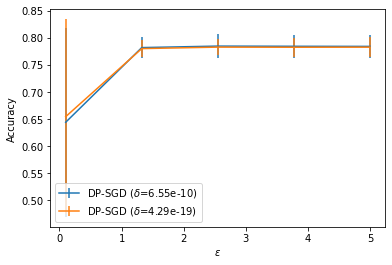

In [39]:
lamb = 0
n_iter = 500
n_batch = 1
gamma = 0.2
# gamma = lambda t: 1 / np.sqrt(t)

eps_list = np.linspace(0.1, 5.0, num=5)
delta_list = [1. / n_train**2, 1. / n_train**4]
n_runs = 10
    
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
accuracy = np.zeros((len(eps_list), len(delta_list), n_runs))
for j, delta in enumerate(delta_list):
    for i, eps in enumerate(eps_list):
        for r in range(n_runs):
            mlr = MyPrivateSGDLogisticRegression(gamma, n_iter, eps, delta, lamb, n_batch=n_batch, random_state=r)
            mlr.fit(X_train, y_train)
            accuracy[i, j, r] = mlr.score(X_test, y_test)

                    
    
    ax.errorbar(eps_list, accuracy[:, j, :].mean(axis=1), accuracy[:, j, :].std(axis=1),
                    label='DP-SGD ($\delta$=' + "{:.2e}".format(delta) + ')')

plt.xlabel("$\epsilon$")
plt.ylabel("Accuracy")
ax.legend();

## <font color='blue'>Bonus Question</font> (extending the scope of private SGD)
*(You won't be penalized if you don't answer this question; but can get bonus points if you do)*

Let us consider the following extensions, which were briefly discussed in the lecture:
1. *$\ell_2$-regularization*: What is the sensitivity of the stochastic gradient when adding $\ell_2$-regularization to the objective (parameter `lamb` in the code above)? Adapt your code if needed.
2. *Mini-batch*: What is the sensitivity of a stochastic gradient when it is evaluated on a mini-batch of $b$ data points (parameter `n_batch` in the code above)? Adapt your code if needed.
3. *Gradient clipping*: If the loss function $L$ is not Lipschitz, or when the Lipschitz constant is difficult to bound, the idea of gradient clipping consists in rescaling each individual gradient that have a norm larger than some constant $C$ to have norm equal to $C$:
$$\text{clip}(\nabla L(\theta;x,y), C) = \min\Big(1,\frac{C}{\|\nabla L(\theta;x,y)\|_2}\Big)\nabla L(\theta;x,y)$$

Explain how this allows to bound the gradient sensitivity without any assumption on the Lipschitzness of the loss. Implement this variant in a function `private_sgd_with_clipping` and explore how to choose the value of $C$ for logistic regression on the *unnormalized* version of your dataset.

> These extensions to the basic setup of differentially private stochastic gradient descent (SGD) are crucial for enhancing privacy while maintaining the utility of the model. Let's delve into each of them: 
> - **ℓ2-Regularization :** 
>> ℓ2-regularization adds a penalty to the loss function proportional to the square of the magnitude of the coefficients. 
>> The sensitivity of the stochastic gradient with ℓ2-regularization does not change the fundamental sensitivity of the SGD step because the regularization term depends on the parameters $\theta$ rather than the data. However, it indirectly influences sensitivity by potentially keeping the weights smaller, which can affect the gradients' magnitude through the loss function.

> - **Mini-batch :**
>> When evaluating the stochastic gradient on a mini-batch of b data points, the sensitivity of the stochastic gradient increases linearly with the batch size b. This is because the gradient is now the sum of the gradients over b points, making the maximum change (sensitivity) b times larger if each point could change the gradient by a maximum amount. 
>>
>> The sensitivity of a stochastic gradient evaluated on a mini-batch of size b is b times the sensitivity of the gradient evaluated on a single data point, assuming the worst-case scenario where each data point in the batch could contribute to the maximum possible change in the gradient.

> - **Gradient Clipping**
>> Gradient clipping bounds the sensitivity of the gradient without any assumption on the Lipschitzness of the loss by ensuring that no individual gradient exceeds a norm of C. This is crucial in differentially private SGD, where controlling the gradient's sensitivity is necessary to apply noise for privacy.
>>
>> By clipping each gradient to have a maximum norm of C, we ensure that the maximum contribution of any single data point to the gradient is bounded. This allows us to add noise scaled to C (plus any additional sensitivity from batching or other sources) to achieve differential privacy. The choice of C is critical: too small, and we might lose important signal in the gradients; too large, and we don't sufficiently bound sensitivity to add effective noise for privacy.

> Choosing C for logistic regression on an unnormalized dataset involves experimentation and domain knowledge. Too small a C may lead to underfitting by clipping too much useful signal, while too large a C might not sufficiently protect privacy. A practical approach is to start with a C based on observed gradients' norms during initial non-private training runs and adjust based on privacy-utility trade-offs observed in validation performance.